<a href="https://colab.research.google.com/github/yuzushi0225/OpenPose/blob/main/%E6%96%B0%E3%83%BB%E5%8D%92%E6%A5%AD%E7%A0%94%E7%A9%B6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pose Detection with OpenPose

This notebook uses an open source project [CMU-Perceptual-Computing-Lab/openpose](https://github.com/CMU-Perceptual-Computing-Lab/openpose.git) to detect/track multi person poses on a given video.

Please read the [OpenPose license](https://github.com/CMU-Perceptual-Computing-Lab/openpose/blob/master/LICENSE) before running this script.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
OPENPOSE_PATH="./openpose/"
HOME_PATH='./'

In [ ]:
!echo $HOME_PATH

##Install OpenPose

In [ ]:
#@title
!pip install ffmpeg-python
from os.path import exists, join, basename, splitext

def show_local_mp4_video(file_name, width=640, height=480):
  import io
  import base64
  from IPython.display import HTML
  video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
  return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                        <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                      </video>'''.format(width, height, video_encoded.decode('ascii')))


# see: https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/949
# install new CMake becaue of CUDA10
!wget -q https://cmake.org/files/v3.17/cmake-3.17.2-Linux-x86_64.tar.gz
!tar xfz cmake-3.17.2-Linux-x86_64.tar.gz --strip-components=1 -C /usr/local

# install system dependencies
!apt-get -qq install -y libatlas-base-dev libprotobuf-dev libleveldb-dev libsnappy-dev libhdf5-serial-dev protobuf-compiler libgflags-dev libgoogle-glog-dev liblmdb-dev opencl-headers ocl-icd-opencl-dev libviennacl-dev

git_repo_url = 'https://github.com/CMU-Perceptual-Computing-Lab/openpose.git'
project_name = splitext(basename(git_repo_url))[0]
!rm -rf openpose
# clone openpose
!git clone -q --depth 1 $git_repo_url
# --recursive necessary in the line below, as otherwise you can (sometimes) get "lpthreads" errors in cmake ("undefined reference to `pthread_create'" etc). See, for example, https://github.com/facebookarchive/caffe2/issues/1234
!sed -i 's/execute_process(COMMAND git checkout --recursive master WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/execute_process(COMMAND git checkout f019d0dfe86f49d1140961f8c7dec22130c83154 WORKING_DIRECTORY ${CMAKE_SOURCE_DIR}\/3rdparty\/caffe)/g' openpose/CMakeLists.txt
!cd openpose && git submodule update --init --recursive --remote

Workaround for server problem (run if you see `file DOWNLOAD HASH mismatch` when building OpenPose):

In [ ]:
!cp "/content/drive/MyDrive/proB/models.zip" /content

In [ ]:
#@title
# Workaround for server connection problem ("file DOWNLOAD HASH mismatch"),see, e.g.,
# https://github.com/CMU-Perceptual-Computing-Lab/openpose/issues/1602#issuecomment-641653411
!apt-get install unzip

# !wget -O models.zip  --no-check-certificate -r 'https://drive.google.com/uc?id=1QCSxJZpnWvM00hx49CJ2zky7PWGzpcEh&export=download'
!unzip -o models.zip -d openpose

In [ ]:
# use 'sed' to comment out the line in the OpenPose repo that downloads the model from the failed link
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.1.sh
! sed -i 's/executeShInItsFolder "getModels.sh"/# executeShInItsFolder "getModels.sh"/g' ./openpose/scripts/ubuntu/install_openpose_JetsonTX2_JetPack3.3.sh
! sed -i 's/download_model("BODY_25"/# download_model("BODY_25"/g' ./openpose/CMakeLists.txt
! sed -i 's/78287B57CF85FA89C03F1393D368E5B7/# 78287B57CF85FA89C03F1393D368E5B7/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (COCO)"/# download_model("body (COCO)"/g' ./openpose/CMakeLists.txt
! sed -i 's/5156d31f670511fce9b4e28b403f2939/# 5156d31f670511fce9b4e28b403f2939/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("body (MPI)"/# download_model("body (MPI)"/g' ./openpose/CMakeLists.txt
! sed -i 's/2ca0990c7562bd7ae03f3f54afa96e00/# 2ca0990c7562bd7ae03f3f54afa96e00/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("face"/# download_model("face"/g' ./openpose/CMakeLists.txt
! sed -i 's/e747180d728fa4e4418c465828384333/# e747180d728fa4e4418c465828384333/g' ./openpose/CMakeLists.txt
! sed -i 's/download_model("hand"/# download_model("hand"/g' ./openpose/CMakeLists.txt
! sed -i 's/a82cfc3fea7c62f159e11bd3674c1531/# a82cfc3fea7c62f159e11bd3674c1531/g' ./openpose/CMakeLists.txt

In [ ]:
! ls -lha /usr/lib/x86_64-linux-gnu

In [ ]:
# build openpose
# CUDA
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. -DUSE_CUDNN=OFF && make -j`nproc`
#!cd openpose && rm -rf build || true && mkdir build && cd build && cmake .. && make -j`nproc`
# CPU
# !cd openpose && rm -rf build || true && mkdir build && cd build && cmake -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF .. && cmake --build . --config Release && make -j`nproc`

!cd openpose && rm -rf build || true && mkdir build

In [ ]:
cmake_file='/content/openpose/CMakeLists.txt'
!cd openpose && sed -i 's/-DBUILD_python=OFF/-DBUILD_python=ON/g' $cmake_file
!cd openpose && sed -i 's/-DBUILD_python_layer=OFF/-DBUILD_python_layer=ON/g' $cmake_file

!cd openpose && sed -i 's/option(BUILD_PYTHON "Build OpenPose python." OFF)/option(BUILD_PYTHON "OpenPose python." ON)\noption(BUILD_BIN_FOLDER "Copy 3rd-party DLL files." ON)/g' $cmake_file

In [ ]:
# CUDA
!cd openpose && cd build && cmake .. -DUSE_CUDNN=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so' && make -j`nproc`

 # CPU
# !cd openpose && cd build && cmake .. -DGPU_MODE=CPU_ONLY -DUSE_MKL=OFF -DGENERATE_PYTHON_BINDINGS:BOOL="1" -DPYTHON_LIBRARY='/usr/lib/x86_64-linux-gnu/libpython3.10.so'
# !cd openpose && cd build && make -j`nproc`

-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc - works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ - works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- GCC detected, adding compile flags
-- GCC detected, adding compile flags
-- Looking for pthread.h
-- Looking for pthread.h - found
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD
-- Performing Test CMAKE_HAVE_LIBC_PTHREAD - Success
-- Found Threads: TRUE  
-- Found CUDA: /usr/local/cuda (found version "12.2") 
-- Building with CUDA.
-- CUDA detected: 12.2
-- Added CUDA NVCC flags for: sm_75
-- Found cuDNN

## Try on YouTube video

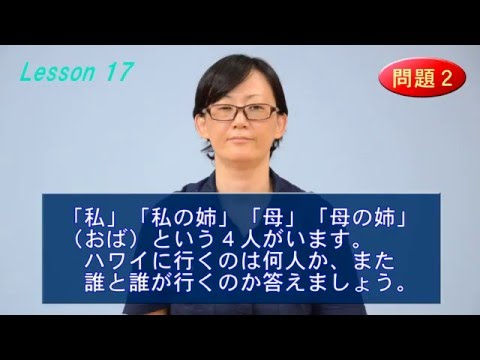

In [ ]:
from IPython.display import YouTubeVideo
YOUTUBE_ID = 'yaMuEAARlsk'
YouTubeVideo(YOUTUBE_ID)

Download the above youtube video, cut and do the pose detection on that section:

In [ ]:
# ! sudo -H pip install --upgrade youtube-dl
! pip install --upgrade --force-reinstall "git+https://github.com/ytdl-org/youtube-dl.git"

  Cloning https://github.com/ytdl-org/youtube-dl.git to /tmp/pip-req-build-aglkc2za
  Running command git clone --filter=blob:none --quiet https://github.com/ytdl-org/youtube-dl.git /tmp/pip-req-build-aglkc2za
  Resolved https://github.com/ytdl-org/youtube-dl.git to commit d55d1f423d6473ae6a9e13462d94bad1d71d28e0
  Preparing metadata (setup.py) ... done
  Created wheel for youtube_dl: filename=youtube_dl-2021.12.17-py2.py3-none-any.whl size=1972716 sha256=2c81467426aedb882d2513142d269be84840d753195cc93b9a3a3adebb684560
  Stored in directory: /tmp/pip-ephem-wheel-cache-u62pdoat/wheels/64/8e/40/866e846163e3e4859bbe820ff8847ec97f4320864f1525aa9a
Successfully built youtube_dl


In [ ]:
!rm -rf youtube.mp4
# download the youtube with the given ID
!youtube-dl -f 'bestvideo[ext=mp4]' --output "youtube.%(ext)s" https://www.youtube.com/watch?v=$YOUTUBE_ID
# cut the video
!ffmpeg -y -loglevel info -i youtube.mp4 -ss 10 -t 7 video.mp4

[youtube] yaMuEAARlsk: Downloading webpage
[youtube] yaMuEAARlsk: Downloading API JSON
[youtube] yaMuEAARlsk: Downloading player 03dbdfab
[dashsegments] Total fragments: 2
[download] Destination: youtube.mp4
[download] 100% of 15.72MiB in 00:00
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --e

In [ ]:
# detect poses on the these 5 seconds
!cd $OPENPOSE_PATH && rm ../openpose.avi
!cd $OPENPOSE_PATH && chmod -R 755 './build/'
!cd $OPENPOSE_PATH && ./build/examples/openpose/openpose.bin --video ../video.mp4 --write_json ./output/ --display 0  --write_video ../openpose.avi --face
# convert the result into MP4
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

rm: cannot remove '../openpose.avi': No such file or directory
Starting OpenPose demo...
Configuring OpenPose...
Starting thread(s)...
Auto-detecting all available GPUs... Detected 1 GPU(s), using 1 of them starting at GPU 0.
OpenPose demo successfully finished. Total time: 39.349395 seconds.
ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-

samplecode



Finally, visualize the result:

In [ ]:
import os

# pyopenpose.soファイルの移動
source_path = "/content/openpose/build/python/openpose/CMakeFiles/pyopenpose.dir/"
destination_path = "/content/openpose/build/python/openpose/"

# ファイルを移動する
os.system(f"mv {source_path}pyopenpose.*.so {destination_path}")


256


## Download the detected video

画像


In [ ]:
from google.colab import files
from IPython.display import Image, display
import os
import shutil

# アップロードされたファイルを保存するディレクトリを作成
input_dir = "input_images"
output_dir = "output"

os.makedirs(input_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

# 画像をアップロード
uploaded = files.upload()

# アップロードされたファイルの名前を取得し、input_imagesディレクトリに移動
for filename in uploaded.keys():
    # 安全なファイル名に変更（スペースをアンダースコアに置換し、括弧を削除）
    safe_filename = filename.replace(" ", "_").replace("(", "").replace(")", "")
    file_path = os.path.join(input_dir, safe_filename)
    with open(file_path, "wb") as f:
        f.write(uploaded[filename])

    # 元のファイル名から安全なファイル名へのマッピングを保存
    uploaded[filename] = safe_filename

# OpenPoseを実行
!cd openpose && ./build/examples/openpose/openpose.bin --image_dir ../input_images/ --write_images ../output/ --display 0

# 出力画像を表示
for filename in uploaded.values():
    output_image_path = os.path.join(output_dir, filename.replace('.jpg', '_rendered.png'))
    if os.path.exists(output_image_path):
        display(Image(output_image_path))
    else:
        print(f"OpenPose output image for {filename} not found. Check the OpenPose execution for errors.")

In [ ]:
import os
import sys
import cv2
import csv

# OpenPose Python バインディングのディレクトリを sys.path に追加
sys.path.append('/content/openpose/build/python')
from openpose import pyopenpose as op

# カレントディレクトリの取得
dir_path = os.getcwd()
sys.path.append(os.path.join(dir_path, 'openpose/build/python'))

def process_image(image_path):
    params = dict()
    params["model_folder"] = os.path.join(dir_path, "openpose/models/")
    params["hand"] = True
    params["face"] = True


    # OpenPoseの初期化
    opWrapper = op.WrapperPython()
    opWrapper.configure(params)
    opWrapper.start()

    # 画像を読み込む
    image = cv2.imread(image_path)
    image_height = image.shape[0]  # 画像の高さを取得
    datum = op.Datum()
    datum.cvInputData = image

    # OpenPoseで処理
    opWrapper.emplaceAndPop(op.VectorDatum([datum]))

    return datum, image_height

# 必要なキーポイントの名称とインデックス
required_keypoints = [
    ("Nose", 0),
    ("Neck", 1),
    ("RShoulder", 2),
    ("RElbow", 3),
    ("RWrist", 4),
    ("LShoulder", 5),
    ("LElbow", 6),
    ("LWrist", 7),
    ("RHip", 8),
    ("RKnee", 9),
    ("RAnkle", 10),
    ("LHip", 11),
    ("LKnee", 12),
    ("LAnkle", 13),
    ("REye", 14),
    ("LEye", 15),
    ("REar", 16),
    ("LEar", 17)
]

def writeCSV(header, data):
    with open('output.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerow(data)

def main(image_path):
    datum, image_height = process_image(image_path)
    header = []
    data = []

    if datum.poseKeypoints is not None:
        for name, index in required_keypoints:
            if index < len(datum.poseKeypoints[0]):
                keypoint = datum.poseKeypoints[0][index]
                header.extend(["{}_X".format(name), "{}_Y".format(name)])

                # Y座標を反転させる
                data.extend([keypoint[0], image_height - keypoint[1]])
            else:
                header.extend(["{}_X".format(name), "{}_Y".format(name)])
                data.extend([None, None])
    else:
        for name, index in required_keypoints:

            header.extend(["{}_X".format(name), "{}_Y".format(name)])
            data.extend([None, None])

    writeCSV(header, data)

if __name__ == '__main__':
    image_path = input("Enter the path to the image file: ")
    # CSVファイルの初期化
    with open('output.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Keypoints"])

    # メイン処理の実行
    main(image_path)


In [ ]:
!pip install --upgrade youtube-dl ffmpeg-python


In [ ]:
from google.colab import files

uploaded = files.upload()

# アップロードされたファイルの名前を取得し、指定のファイル名に保存
for filename in uploaded.keys():
    uploaded_filename = 'douga.mp4'  # カスタムの動画ファイル名に置き換える
    with open(uploaded_filename, 'wb') as f:
        f.write(uploaded[filename])


In [ ]:
import os
import ffmpeg

# OpenPoseがすでにインストールされ、環境に設定されていると仮定します
!cd $OPENPOSE_PATH && rm -rf ./output/*
!cd $OPENPOSE_PATH && ./build/examples/openpose/openpose.bin --video ../douga.mp4 --write_json ./output/ --display 0 --write_video ../openpose.avi --face


In [ ]:
!ffmpeg -y -loglevel info -i openpose.avi output.mp4

from IPython.display import HTML

def show_local_mp4_video(file_name, width=640, height=480):
    import io
    import base64

    video_encoded = base64.b64encode(io.open(file_name, 'rb').read())
    return HTML(data='''<video width="{0}" height="{1}" alt="test" controls>
                          <source src="data:video/mp4;base64,{2}" type="video/mp4" />
                        </video>'''.format(width, height, video_encoded.decode('ascii')))

show_local_mp4_video('output.mp4', width=960, height=720)


In [ ]:
import os
import sys
import cv2
import csv
from openpose import pyopenpose as op

# カレントディレクトリの取得
dir_path = os.getcwd()
sys.path.append(os.path.join(dir_path, 'openpose/build/python'))

def process_frame(frame):
    params = dict()
    params["model_folder"] = os.path.join(dir_path, "openpose/models/")
    params["hand"] = True
    params["face"] = True

    # OpenPoseの初期化
    opWrapper = op.WrapperPython()
    opWrapper.configure(params)
    opWrapper.start()

    # 動画を処理
    datum = op.Datum()
    datum.cvInputData = frame
    opWrapper.emplaceAndPop(op.VectorDatum([datum]))

    return datum

# 必要なキーポイントの名称とインデックス
required_keypoints = [
    ("Nose", 0),
    ("Neck", 1),
    ("RShoulder", 2),
    ("RElbow", 3),
    ("RWrist", 4),
    ("LShoulder", 5),
    ("LElbow", 6),
    ("LWrist", 7),
    ("RHip", 8),
    ("RKnee", 9),
    ("RAnkle", 10),
    ("LHip", 11),
    ("LKnee", 12),
    ("LAnkle", 13),
    ("REye", 14),
    ("LEye", 15),
    ("REar", 16),
    ("LEar", 17)
]

def writeCSV(header, data):
    with open('output.csv', 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(header)
        writer.writerow(data)

def main(video_path):
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # フレームの高さを取得

    # CSVファイルにヘッダーを書き込み
    with open('output.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        header = []
        for name, _ in required_keypoints:
            header.extend(["{}_X".format(name), "{}_Y".format(name)])
        writer.writerow(header)

    for frame_idx in range(frame_count):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            continue

        datum = process_frame(frame)
        data = []
        for name, index in required_keypoints:
            if datum.poseKeypoints is not None and index < len(datum.poseKeypoints[0]):
                keypoint = datum.poseKeypoints[0][index]
                # Y座標を上下反転
                flipped_y = frame_height - keypoint[1]
                data.extend([keypoint[0], flipped_y])
            else:
                data.extend([None, None])

        writeCSV([], data)

    cap.release()

if __name__ == '__main__':
    video_path = input("Enter the path to the video file: ")
    main(video_path)
